In [84]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import causallearn

from causallearn.utils.cit import *
from causallearn.graph.GraphClass import CausalGraph
import pandas as pd
from itertools import combinations, permutations
from numpy import ndarray
from typing import Dict, List, Tuple
from causallearn.utils.cit import fisherz
import random


import time

import scipy as sp

# Initialize Dataset, SISO

## From Controllable Canonical Form:

In [60]:
def gram_schmidt_normalized(A):
    assert A.shape[0] == A.shape[1]
    A_GS = np.zeros(A.shape)
    A_GS[:, 0] = A[:, 0] / np.linalg.norm(A[:, 0])
    for k in np.arange(1, A.shape[1]):
#         print("\n", k, ":")
        temp_vec = np.zeros(A.shape[0])
        for j in range(k):
#             print(j)
            temp_vec += (A[:, k].T @ A_GS[:, j]) * A_GS[:, j]
        A_GS_vec_unnormalized = A[:, k] - temp_vec
        A_GS[:, k] = A_GS_vec_unnormalized / np.linalg.norm(A_GS_vec_unnormalized)
    
    assert np.linalg.det(A_GS) != 0
    
    if np.linalg.det(A_GS) < 0:
        A_GS[:, 0] *= -1
    
    return A_GS

def ccf_from_vec(vec):
    n = vec.shape[0]
    A_temp = np.block([np.zeros((n-1, 1)), np.identity(n-1)])
    A = np.block([[A_temp], [-np.flip(vec)]])
    
    return A

def ccf_from_matrices(A, b):
    # INCOMPLETE; edit below.
    
    assert A.shape[0] == A.shape[1] == b.shape[0]
    assert b.shape[1] == 1
    
    n = A.shape[0]
    print("n:", n)
#     A_svs = np.linalg.svd(A)[1]
    A_eigs = np.linalg.eig(A)[0]
    
    ccf_temp_1 = b
    for k in np.arange(1, n):
        ccf_temp_1 = np.block([ccf_temp_1, np.linalg.matrix_power(A, k) @ b])
    
    ccf_temp_2 = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i+j < n-1:
                # INCOMPLETE
#                 print("A_eigs.shape:", A_eigs.shape)
#                 print("n-i-j-1:", n-i-j-1)
                ccf_temp_2[i, j] = A_eigs[n-i-j-1]
            elif i+j == n-1:
                ccf_temp_2[i, j] = 1
            else:
                continue
                
    ccf_transform = ccf_temp_1 @ ccf_temp_2
    
    print("\nccf_temp_1:", ccf_temp_1)
    print("\nccf_temp_2:", ccf_temp_2)
    print("\nccf_transform:", ccf_transform)
    print("\n")
    print("np.linalg.det(ccf_temp_1):", np.linalg.det(ccf_temp_1))
    print("np.linalg.det(ccf_temp_2):", np.linalg.det(ccf_temp_2))
    print("np.linalg.det(ccf_transform):", np.linalg.det(ccf_transform))
    
    return ccf_transform, np.linalg.solve(ccf_transform, A @ ccf_transform)
    


In [61]:
# # f = np.poly([1,-2,3])

# num_states_temp = 20
# beta_temp = 0.95
# vec_roots_temp = (np.random.rand(num_states_temp)*2-1) * beta_temp
# f = -np.flip(np.poly(vec_roots_temp))[1:]
# # f
# vec_roots_temp

# temp_matrix = np.zeros((3, 3))
# np.fill_diagonal(temp_matrix, np.array([1, 2, 3]))
# temp_matrix

In [76]:
beta = 0.95
beta_discount_factor = 1.0
num_states = 20
num_inputs = 1
num_outputs = 1

U = gram_schmidt_normalized(np.random.randn(num_states, num_states) + 5*np.ones((num_states, num_states)))
V = gram_schmidt_normalized(np.random.randn(num_states, num_states) + 5*np.ones((num_states, num_states)))
diag = np.zeros((num_states, num_states))
np.fill_diagonal(diag, (np.random.rand(num_states)*2 - 1) * beta * beta_discount_factor)

A = U @ diag @ V.T
B = np.random.randn(num_states, num_inputs)
C = np.random.randn(num_outputs, num_states)

np.linalg.svd(A_0)[1]


# ccf_transform, A = ccf_from_matrices(A_0, B_0)



array([0.8817406 , 0.69966386, 0.58513995, 0.52106969, 0.51910754,
       0.4926434 , 0.45950398, 0.39526017, 0.38168297, 0.36741677,
       0.34674612, 0.25091072, 0.2398635 , 0.2314813 , 0.22595674,
       0.21815925, 0.15038761, 0.0486994 , 0.01909832, 0.01803784])

In [77]:
# beta = 0.95
# beta_discount_factor = 0.8
# num_states = 20
# num_inputs = 1
# num_outputs = 1

# # vec_for_A = np.random.randn(num_states,)
# # vec_for_A = np.block([np.zeros(num_states-1), -beta**num_states])
# vec_A_roots = (np.random.rand(num_states)*2-1) * beta * beta_discount_factor
# vec_for_A = -np.flip(np.poly(vec_A_roots)[1:])

# A_0 = ccf_from_vec(vec_for_A)
# B_0 = np.block([np.zeros(num_states-1), 1]).reshape((num_states, 1))
# C_0 = np.random.randn(num_outputs, num_states)
# theta_ground_truth = np.block([-np.flip(vec_for_A), C_0])

# transform_matrix = gram_schmidt_normalized(np.random.randn(num_states, num_states) + 5*np.ones((num_states, num_states)))
# A = transform_matrix @ A_0 @ transform_matrix.T
# B = transform_matrix @ B_0
# C = C_0 @ transform_matrix.T



In [78]:
T = 2
num_traj = 20000
# num_traj = 10000

for traj_id in range(num_traj):
    x_vec = np.zeros((num_states, T))
    y_vec = np.zeros((num_outputs, T))
    x_vec[:, 0] = np.random.randn(num_states)
    y_vec[:, 0] = C @ x_vec[:, 0]
    
    u_vec = np.random.randn(num_inputs, T) * np.sqrt(1 - beta**2)
    #w_vec = np.random.randn(2,T) * np.sqrt(1 - alpha**2 - beta**2)
    
    for t in range(T-1):
    #     print(t)
        x_vec[:, t+1] = A @ x_vec[:, t] + B @ u_vec[:,t] #+ w_vec[:, t]
        y_vec[:, t+1] = C @ x_vec[:, t+1]
    
    y_u_vec = np.block([[y_vec], [u_vec]])
    
    # traj_dataset indices: Sample index, variable index, time
    if traj_id == 0:
        traj_dataset = np.zeros((num_traj, y_u_vec.shape[0], y_u_vec.shape[1]))
        traj_dataset[0, :, :] = y_u_vec
    else:
        traj_dataset[traj_id, :, :] = y_u_vec

In [ ]:
# print(A)
# print("\n")
# print(B)
# print("\n")
# print(C)

In [79]:
# plt.plot(traj_dataset)
traj_dataset.shape

(20000, 2, 2)

In [80]:
assert traj_dataset.shape == (num_traj, num_outputs + num_inputs, T)

In [81]:
num_traj, num_quantities, _ = traj_dataset.shape
# num_quantities

# Modified PC Algorithm for Learning Input vs. Output

In [82]:
def correlation_test(data, m, rho_m):
    num_traj, num_quantities, _ = data.shape
    input_indices = []
    
    for i in range(num_quantities):
        node_indices_to_test = np.random.choice(num_quantities, m)
        for count, j in enumerate(node_indices_to_test):
            corr = sp.stats.pearsonr(traj_dataset[:, j, 0], traj_dataset[:, i, 1])[0]
            if corr >= rho_m:
                break
            if count == m-1:
                input_indices.append(i)
    
    return input_indices

def correlation_test_SISO(data):
    # Indices: Variable index, time
    # For variable 0 at time t+1:
    corr_00_01 = sp.stats.pearsonr(traj_dataset[:, 0, 0], traj_dataset[:, 0, 1])[0]
    corr_10_01 = sp.stats.pearsonr(traj_dataset[:, 1, 0], traj_dataset[:, 0, 1])[0]
    # For variable 1 at time t+1:
    corr_00_11 = sp.stats.pearsonr(traj_dataset[:, 0, 0], traj_dataset[:, 1, 1])[0]
    corr_10_11 = sp.stats.pearsonr(traj_dataset[:, 1, 0], traj_dataset[:, 1, 1])[0]
    # Store correlations into list:
    corr_list = [corr_00_01, corr_10_01, corr_00_11, corr_10_11]
    
    # Indices: Variable index at time t+1
    corr_0 = max(abs(corr_00_01), abs(corr_10_01))
    corr_1 = max(abs(corr_00_11), abs(corr_10_11))
    
    if corr_0 < corr_1:
        return [corr_list, 0]
    else:
        return [corr_list, 1]

In [85]:
corrs, input_index = correlation_test_SISO(traj_dataset)

print(corrs)
print(input_index)

[0.10996622297599337, -0.4301689973695266, 0.01924249406235584, -0.004367707577172814]
1


# System ID, via Goodwin and Sin:

In [91]:
T = 1000
num_traj = 1
assert T > 2 * num_states

In [92]:
np.linalg.eig(A)[0]

array([-0.64112398+0.j        ,  0.6377815 +0.j        ,
       -0.26912405+0.31412698j, -0.26912405-0.31412698j,
       -0.23554518+0.30784792j, -0.23554518-0.30784792j,
        0.18522157+0.32863698j,  0.18522157-0.32863698j,
       -0.22361877+0.067832j  , -0.22361877-0.067832j  ,
       -0.11397006+0.22050163j, -0.11397006-0.22050163j,
       -0.05272273+0.21507153j, -0.05272273-0.21507153j,
        0.38440272+0.j        ,  0.22070573+0.20592738j,
        0.22070573-0.20592738j,  0.26035627+0.0676664j ,
        0.26035627-0.0676664j ,  0.17871024+0.j        ])

In [93]:
for traj_id in range(num_traj):
    x_vec = np.zeros((num_states, T))
    y_vec = np.zeros((num_outputs, T))
    x_vec[:, 0] = np.random.randn(num_states)
    y_vec[:, 0] = C @ x_vec[:, 0]
    
    u_vec = np.random.randn(num_inputs, T)
    #w_vec = np.random.randn(2,T) * np.sqrt(1 - alpha**2 - beta**2)
    
    for t in range(T-1):
    #     print(t)
        x_vec[:, t+1] = A @ x_vec[:, t] + B @ u_vec[:,t] #+ w_vec[:, t]
        y_vec[:, t+1] = C @ x_vec[:, t+1]
    
    y_u_vec = np.block([[y_vec], [u_vec]])
    
    # traj_dataset indices: Sample index, variable index, time
    if traj_id == 0:
        traj_for_sysID = np.zeros((num_traj, y_u_vec.shape[0], y_u_vec.shape[1]))
        traj_for_sysID[0, :, :] = y_u_vec
    else:
        traj_for_sysID[traj_id, :, :] = y_u_vec



In [94]:
traj_for_sysID[0, :, :]

array([[ 7.17258412, -5.02519854, -0.67116669, ..., -1.25100228,
        -2.75787451, -3.93624745],
       [ 0.82545756,  1.11204033, -1.169493  , ...,  0.99119366,
         1.16938546, -0.36029342]])

In [95]:
# # P_0 = np.identity(3)
# # P_0

# v = np.arange(30)


In [96]:
# Least-Squares Algorithm: (Goodwin and Sin, pg. 58)

def least_squares(traj, theta_0, P_0, n, resetting_rate = 100):
    # traj: # variables (y, u) x # Timesteps
    
    assert theta_0.shape[0] == P_0.shape[0] == P_0.shape[1] == 2 * n
    T = traj.shape[1]   
    
    theta_list = [theta_0]
    
    P = P_0
    
    for t in range(n, T):
        
        # \phi(t-1):
        phi = np.block([traj[0, t-n:t], traj[1, t-n:t]]).reshape((2*n, 1))
        # y(t):
        y = traj[0, t]
        
        gain = P @ phi / (1 + phi.T @ P @ phi)
        error = y - phi.T @ theta_list[-1]
        theta_new = theta_list[-1] + gain @ error
        theta_list.append(theta_new)
        
        
#         print("\n")
#         print("gain.shape:", gain.shape)
#         print("error.shape:", error.shape)
#         print("theta_list[-1].shape:", theta_list[-1].shape)
        
        P = P - P @ phi @ phi.T @ P / (1 + phi.T @ P @ phi)
        
        # Resetting:
        if t % resetting_rate == 0:
            P = np.identity(2*n)
        
#         print(t)
#         print(P)
    
    return theta_list

# traj_for_sysID.shape


def output_error(traj, theta, n):
    # INCOMPLETE
    
    assert theta.shape[0] == 2 * n
    
    error_list = []
    
    for t in range(n, T):
        # \phi(t-1):
        phi = np.block([traj[0, t-n:t], traj[1, t-n:t]]).reshape((2*n, 1))
        y = traj[0, t]
        error_list.append(abs(float(y - theta.T @ phi)))
    
    return error_list
    
def avg_of_list(input_list):
    return sum(input_list)/len(input_list)

In [98]:
avg_error_list = []

for count, dim_state in enumerate(range(1, 2*num_states)):
    theta_array = least_squares(traj_for_sysID[0, :, :], np.random.randn(2*dim_state), \
                                np.identity(2*dim_state), dim_state)
#     print(theta_array[-1])
#     print(output_error(traj_for_sysID[0, :, :], theta_array[-1], dim_state))
    avg_error = avg_of_list(output_error(traj_for_sysID[0, :, :], theta_array[-1], dim_state))
    avg_error_list.append(avg_error)
    print(count+1, ":", avg_error)

# theta_array[num_states, 2*num_states]

1 : 0.19313774148198842
2 : 0.18287948455088407
3 : 0.16644401152087748
4 : 0.011350278120740732
5 : 0.006135652883744588
6 : 0.0027164528135413786
7 : 0.007721633859114727
8 : 0.0069924607660399605
9 : 0.0025510150304386098
10 : 0.002419916547549032
11 : 0.0056922792511290695
12 : 0.0031357244586001417
13 : 0.004582373161999764
14 : 0.002263836384147594
15 : 0.004122093438498754
16 : 0.0028347535056990228
17 : 0.0061360305378805255
18 : 0.004377717378258875
19 : 0.004628178685023993
20 : 0.006736547813914812
21 : 0.008770354652668653
22 : 0.008123108181931566
23 : 0.011015266733455976
24 : 0.013161171056088114
25 : 0.006537534543460022
26 : 0.012135743810614306
27 : 0.006188210794652807
28 : 0.007389068878023075
29 : 0.009422514185404128
30 : 0.012951686287423601
31 : 0.004375700469982683
32 : 0.005897472904135989
33 : 0.0045887099719361495
34 : 0.002803748918258424
35 : 0.007753356646955134
36 : 0.005944456852405684
37 : 0.016571332187954528
38 : 0.01652061063718186
39 : 0.0057342580

([<matplotlib.axis.XTick at 0x7fb5e35fd3d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

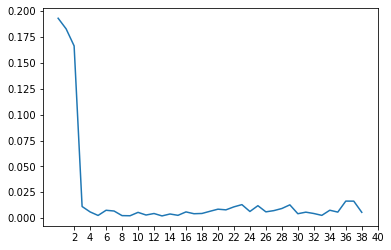

In [99]:
plt.plot(avg_error_list)
plt.xticks(np.arange(2, 41, 2))

([<matplotlib.axis.XTick at 0x7fb5e3a0fc40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

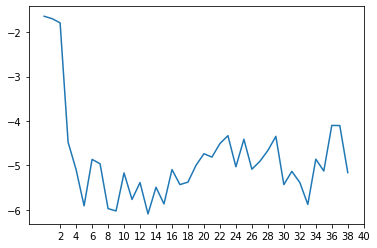

In [100]:
plt.plot(np.log(np.array(avg_error_list)))
plt.xticks(np.arange(2, 41, 2))

In [17]:
dim_state = num_states
theta_array = least_squares(traj_for_sysID[0, :, :], np.random.randn(2*dim_state), \
                                np.identity(2*dim_state), dim_state)
output_error(traj_for_sysID[0, :, :], theta_array[-1], num_states)

[0.0007808887354241456,
 0.0008188216254136904,
 0.0008068562765108922,
 0.0005869723096907364,
 0.0006614091204424355,
 0.0008597339443729979,
 0.0010218483639405918,
 0.001443213468819593,
 0.001658524448970411,
 0.001494845963836866,
 0.0010747029728452873,
 0.0007344665707478271,
 0.00012117156928326267,
 0.00031274213127652217,
 0.0010055342079846596,
 0.0012496504641341666,
 0.001313337614355703,
 0.0012086200757335241,
 0.0011022081299900677,
 0.0007977591814212204,
 0.0004780223384086568,
 3.7445045776962615e-05,
 4.054494362626393e-05,
 1.6514477140683326e-05,
 0.000117975897362399,
 0.00022578047982069194,
 0.0004113411163952918,
 0.0004862718711198255,
 0.0003841059342457598,
 0.0006799120966018979,
 0.0010912274861398785,
 0.0015022140704123998,
 0.0017248707588999324,
 0.001503623896443873,
 0.0012614833631054978,
 0.0011179737165498693,
 0.0009732842315663959,
 0.0009114300581309909,
 0.0006600089655393049,
 0.0007123956274257548,
 0.0002330465691837702,
 4.53123523347365

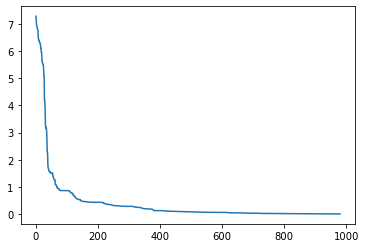

In [18]:
# For perfect match of conjectured and true n (i.e., neither overfitting nor underfitting):
plt.plot(np.linalg.norm((theta_array - theta_ground_truth), axis=1))

In [45]:
# begin_time = time.time()

# m_list = [2*x + 2 for x in list(range(10))]
# rho_min_list = [x * 0.01 + 0.01 for x in list(range(5))]
# input_indices_true = list(range(num_outputs, num_outputs + num_inputs))
# num_trials = 10

# false_positive_avg_array = np.zeros((len(m_list), len(rho_min_list)))
# missed_detection_avg_array = np.zeros((len(m_list), len(rho_min_list)))

# for count_m, m in enumerate(m_list):
#     print("\n")
#     print("count_m:", count_m)
#     for count_rho, rho_min in enumerate(rho_min_list):
#         print("count_rho", count_rho)
#         false_positive_quantity_list = []
#         missed_detection_quantity_list = []
#         for trial_id in range(num_trials):
#             input_indices_est = correlation_test(traj_dataset, m, rho_min)
#             false_positive_quantity_list.append(len([k for k in input_indices_est if k not in input_indices_true]))
#             missed_detection_quantity_list.append(len([k for k in input_indices_true if k not in input_indices_est]))
#         false_positive_avg_array[count_m, count_rho] = sum(false_positive_quantity_list)/len(false_positive_quantity_list)
#         missed_detection_avg_array[count_m, count_rho] = sum(missed_detection_quantity_list)/len(missed_detection_quantity_list)

# end_time = time.time()
# print("\nTime:", end_time - begin_time)

# # print(correlation_test(traj_dataset, 10, 0.05))



In [46]:
# input_indices_est

In [47]:
# print(false_positive_avg_array)
# print(missed_detection_avg_array)

In [48]:
m = 20
rho_min = 0.02

# for i in range(num_quantities):
#     print("\ni:", i)
#     for j in range(num_quantities):
#         print("j:", j, "corr:", sp.stats.pearsonr(traj_dataset[:, j, 0], traj_dataset[:, i, 1])[0])

# print(traj_dataset[:, 10, 0])
# print(traj_dataset[:, 15, 1])

# correlation_test(traj_dataset, m, rho_min)


In [49]:
# # Save results:

# path_directory = "/Users/chih-yuanchiu/Desktop/Code/Causality_Time_Series/data/"

# path_file = path_directory + "false_positive_avg_array.csv"
# false_positive_avg_array_pd = pd.DataFrame(false_positive_avg_array)
# false_positive_avg_array_pd.to_csv(path_file, index=False)

# path_file = path_directory + "missed_detection_avg_array.csv"
# missed_detection_avg_array_pd = pd.DataFrame(missed_detection_avg_array)
# missed_detection_avg_array_pd.to_csv(path_file, index=False)



# Scratch Work

In [ ]:
# list_1 = [3, 4, 5]
# list_2 = [4, 5, 6]

# list_1_not_2 = [k for k in list_1 if k not in list_2]
# list_2_not_1 = [k for k in list_2 if k not in list_1]

# Temp:

In [5]:
# import numpy as np

A = np.array([[10, 6], [6, 10]])
A_half = np.array([[3, 1], [1, 3]])
B = np.array([[4, 0], [0, 1]])
B_half = np.array([[2, 0], [0, 1]])

assert np.array_equal(A_half.T, A_half)
assert np.array_equal(B_half.T, B_half)
assert np.array_equal(A_half @ A_half, A)
assert np.array_equal(B_half @ B_half, B)
assert np.array_equal(A.T, A)
assert np.array_equal(B.T, B)
assert np.all(np.linalg.eig(A)[0] > 0)
assert np.all(np.linalg.eig(B)[0] > 0)
assert np.all(np.linalg.eig(A-B)[0] > 0)

Gamma = np.array([[1, 10], [0, 1]])
print(max(np.linalg.svd(A_half @ Gamma @ np.linalg.inv(A_half))[1]))
print(max(np.linalg.svd(B_half @ Gamma @ np.linalg.inv(B_half))[1]))



12.579494450586084
20.04987562112089


In [8]:
A = np.array([[10, 6], [6, 10]])
A_half = np.array([[3, 1], [1, 3]])
B = np.array([[4, 0], [0, 0.25]])
B_half = np.array([[2, 0], [0, 0.5]])

assert np.array_equal(A_half.T, A_half)
assert np.array_equal(B_half.T, B_half)
assert np.array_equal(A_half @ A_half, A)
assert np.array_equal(B_half @ B_half, B)
assert np.array_equal(A.T, A)
assert np.array_equal(B.T, B)
assert np.all(np.linalg.eig(A)[0] > 0)
assert np.all(np.linalg.eig(B)[0] > 0)
assert np.all(np.linalg.eig(A-B)[0] > 0)

Gamma = np.array([[1, 10], [0, 1]])
print(max(np.linalg.svd(A_half @ Gamma @ np.linalg.inv(A_half))[1]))
print(max(np.linalg.svd(B_half @ Gamma @ np.linalg.inv(B_half))[1]))


12.579494450586084
40.02498439450079


In [ ]:
M = A_half @ np.linalg.inv(B_half)
np.linalg.svd(M)[1]
# print(max(np.linalg.svd(Gamma)[1]))
# print(max(np.linalg.svd(M @ Gamma @ np.linalg.inv(M))[1]))

In [ ]:
A = np.array([[2, 0], [0, 1]])

